# Exploring Machine Learning Models for Heart Attack Prediction

#### CSC 240 - Data Mining
## Dominic Musumeci, Yunsung Hong, Joon Hyup Lee, Claire Kim
 

---

## Overview

This notebook explores various machine learning models to predict the likelihood of a heart attack using a comprehensive dataset. The goal is to evaluate and compare the performance of different algorithms to identify the most effective model for this medical prediction task.

---

## Models to be Explored:
1. Logistic Regression  
2. Decision Tree Classifier  
3. Random Forest Classifier  
4. Support Vector Machine (SVM)  
5. K-Nearest Neighbors (KNN)  
6. Gradient Boosting 
7. Feed Forward Neural Networks
8. Ensemble Learning

---

## Objectives:
- Preprocess the dataset to handle missing values, scale features, and encode categorical variables.
- Train and evaluate each model using appropriate metrics like accuracy, precision, recall, and F1-score.
- Perform hyperparameter tuning to optimize model performance.
- Compare the results of different models and identify the best one for predicting heart attacks.

---


In [1]:
import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [2]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Download latest version
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/dom/.cache/kagglehub/datasets/sulianova/cardiovascular-disease-dataset/versions/1


# The Dataset

# Cardiovascular Disease Dataset: Variable Descriptions

This dataset contains 12 variables that can be used to analyze and predict the likelihood of cardiovascular disease. Below is an overview of each variable and its description:

| **Variable**         | **Description**                                                                 |
|-----------------------|---------------------------------------------------------------------------------|
| **1. Age**           | Age of the patient (in days, converted to years).                                                   |
| **2. Height**        | Height of the patient (in centimeters).                                         |
| **3. Weight**        | Weight of the patient (in kilograms).                                           |
| **4. Gender**        | Gender of the patient: <br> 1 = Female <br> 2 = Male                            |
| **5. Systolic_BP**   | Systolic blood pressure (upper value, in mmHg).                                 |
| **6. Diastolic_BP**  | Diastolic blood pressure (lower value, in mmHg).                                |
| **7. Cholesterol**   | Cholesterol level (categorical): <br> 1 = Normal <br> 2 = Above normal <br> 3 = Well above normal |
| **8. Glucose**       | Glucose level (categorical): <br> 1 = Normal <br> 2 = Above normal <br> 3 = Well above normal |
| **9. Smoking**       | Whether the patient smokes: <br> 0 = No <br> 1 = Yes                           |
| **10. Alcohol**      | Whether the patient consumes alcohol: <br> 0 = No <br> 1 = Yes                 |
| **11. Physical_Activity** | Whether the patient engages in physical activity: <br> 0 = No <br> 1 = Yes         |
| **12. Cardiovascular_Disease** | Target variable: <br> 0 = No cardiovascular disease <br> 1 = Cardiovascular disease present |


In [4]:
heart_attack_df = pd.read_csv(f'{path}/cardio_train.csv', delimiter=';')
heart_attack_df['age'] = (heart_attack_df['age'] / 365.25).round(2)
heart_attack_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.36,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.38,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.63,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.25,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.84,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52.68,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61.88,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.20,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.41,1,163,72.0,135,80,1,2,0,0,0,1


# Data Visualizations
---

## Age Distribution

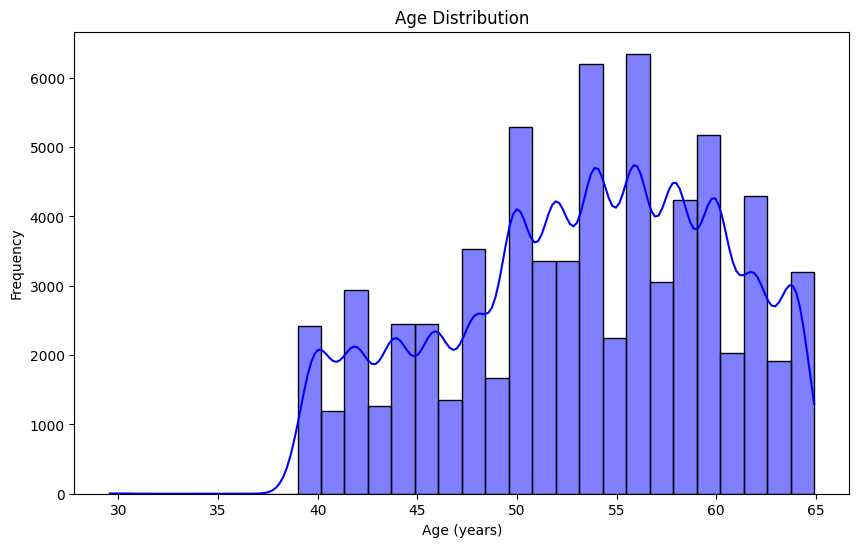

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(heart_attack_df['age'], kde=True, bins=30, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.show()

## Gender Distribution

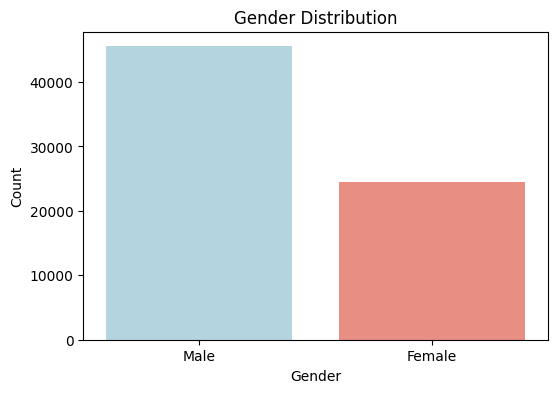

In [6]:
gender_counts = heart_attack_df['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']
gender_counts['gender_label'] = gender_counts['gender'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(6, 4))
sns.barplot(
    x='gender_label',
    y='count',
    data=gender_counts,
    hue='gender_label',
    palette={'Male': 'lightblue', 'Female': 'salmon'},
    dodge=False
)

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend([], [], frameon=False)
plt.show()

## Blood Pressure (ap_hi) vs Cholesterol Levels

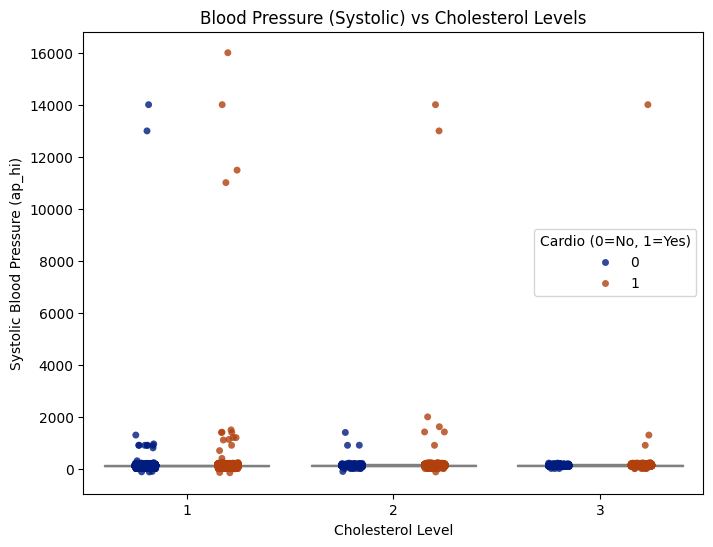

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cholesterol', y='ap_hi', data=heart_attack_df, color="lightgrey", showfliers=False)
sns.stripplot(
    x='cholesterol', 
    y='ap_hi', 
    data=heart_attack_df, 
    hue='cardio', 
    palette="dark",
    dodge=True, 
    alpha=0.8
)
plt.title("Blood Pressure (Systolic) vs Cholesterol Levels")
plt.xlabel("Cholesterol Level")
plt.ylabel("Systolic Blood Pressure (ap_hi)")
plt.legend(title="Cardio (0=No, 1=Yes)")
plt.show()


## Cardiovascular Disease (Target) Distribution

cardio
0    35021
1    34979
Name: count, dtype: int64


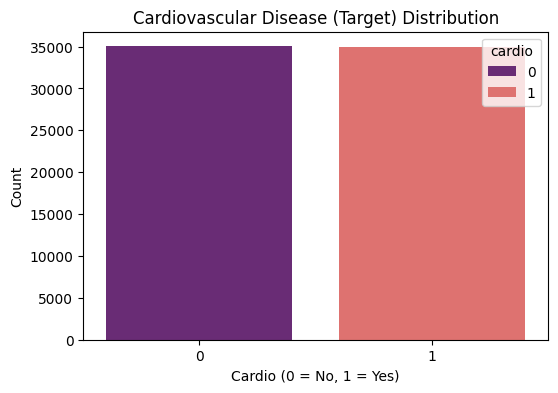

In [8]:
target_counts = heart_attack_df['cardio'].value_counts()

print(target_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="magma", dodge=False)
plt.title("Cardiovascular Disease (Target) Distribution")
plt.xlabel("Cardio (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

## Correlation Heatmap

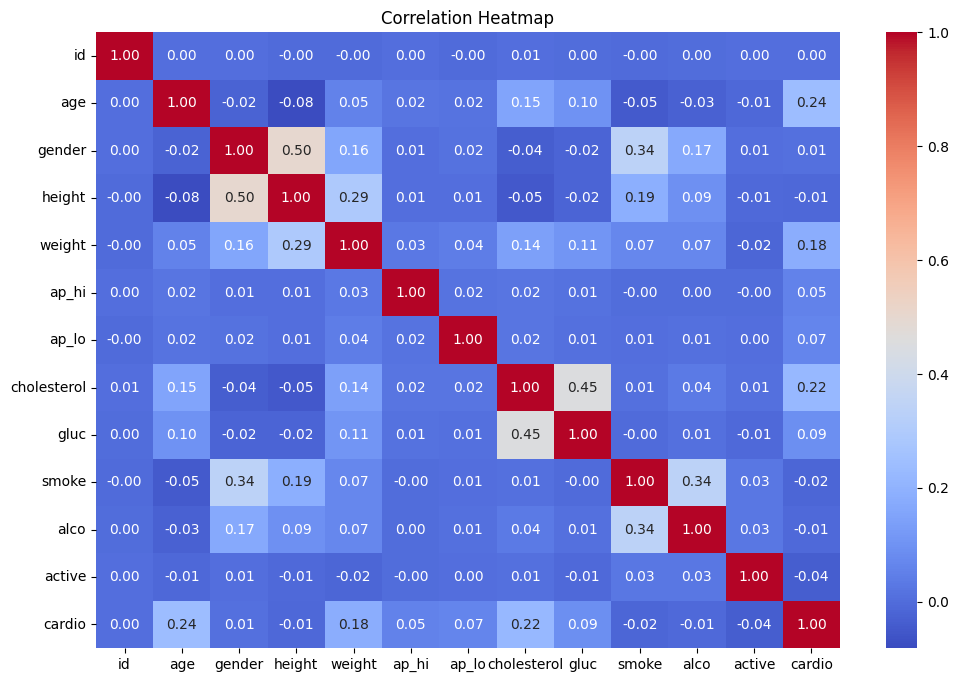

In [9]:
plt.figure(figsize=(12, 8))
corr = heart_attack_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [10]:
heart_attack_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.36,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.38,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.63,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.25,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.84,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52.68,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61.88,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.20,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.41,1,163,72.0,135,80,1,2,0,0,0,1


In [11]:
heart_attack_corr = heart_attack_df.select_dtypes(include='number').corr()['cardio']
heart_attack_corr = heart_attack_corr.drop(labels=['cardio', 'id']).sort_values(ascending=True)

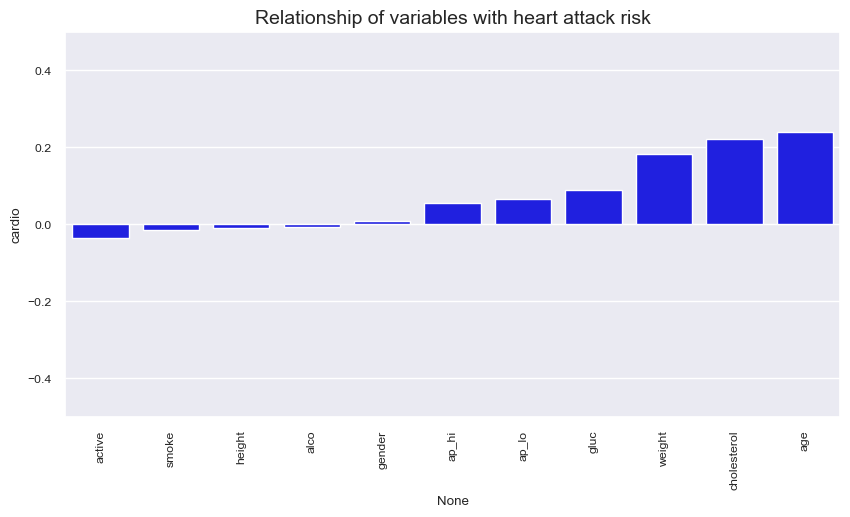

In [12]:
plt.figure(figsize=(10,5))
sns.set(font_scale=0.8)
sns.barplot(x=heart_attack_corr.index, y=heart_attack_corr, color='#0000FF')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title("Relationship of variables with heart attack risk", fontsize=14)
plt.show()

# Data Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [14]:
train_df = heart_attack_df.copy().drop('id', axis=1)

### Remove Outliers

In [15]:
for col in ['height', 'weight', 'ap_hi', 'ap_lo']:
    train_df.drop(train_df[(train_df[col] > train_df[col].quantile(0.975)) | (train_df[col] < train_df[col].quantile(0.025))].index,inplace=True)

### Quantization

In [16]:
train_df['bmi'] = train_df['weight'] / ((train_df['height'] / 100) ** 2)

In [17]:
# # Age
# age_bins = [0, 18, 35, 50, 65, 100]
# age_labels = ['Child', 'Young Adult', 'Middle-Aged', 'Senior', 'Elderly']
# train_df['age'] = pd.cut(train_df['age'], bins=age_bins, labels=age_labels)

# # calculate BMI
# train_df['bmi'] = train_df['weight'] / ((train_df['height'] / 100) ** 2)

# # drop height and weight
# train_df.drop(columns=['height', 'weight'], inplace=True)


# # BMI
# bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
# bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
# train_df['bmi'] = pd.cut(train_df['bmi'], bins=bmi_bins, labels=bmi_labels)

### Mean Arterial Pressure (MAP)

In [18]:
train_df['map'] = (train_df['ap_lo'] + (1/3) * (train_df['ap_hi'] - train_df['ap_lo'])).round(2)
# train_df.drop(columns=['ap_lo', 'ap_hi'], inplace=True)

In [19]:
# map_values = []
# for row in train_df['map']:
#     if row < 69.9:    map_values.append(1)
#     elif row > 70 and row  < 79.9:   map_values.append(2)
#     elif row > 79.9 and row < 89.9:  map_values.append(3)
#     elif row > 89.9 and row < 99.9:  map_values.append(4)
#     elif row > 99.9 and row < 109.9:  map_values.append(5)
#     elif row > 109.9 and row < 119.9:  map_values.append(6)
#     elif row > 119.9:  map_values.append(7)
        
#     else:           map_values.append('Not_Rated')

# train_df['map'] = map_values

In [20]:
train_df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,map
0,50.36,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,90.00
1,55.38,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,106.67
2,51.63,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,90.00
3,48.25,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,116.67
4,47.84,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,73.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,53.93,1,172,70.0,130,90,1,1,0,0,1,1,23.661439,103.33
69994,57.70,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,103.33
69995,52.68,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,93.33
69998,61.41,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,98.33


In [21]:
# cols = ['age', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'map']
cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco']
train_df_encoded = pd.get_dummies(train_df, columns=cols, prefix=cols)
X = train_df_encoded.drop('cardio', axis=1)  # features

y = train_df_encoded['cardio']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
print(X)

         age  height  weight  ap_hi  ap_lo  active        bmi     map  \
0      50.36     168    62.0    110     80       1  21.967120   90.00   
1      55.38     156    85.0    140     90       1  34.927679  106.67   
2      51.63     165    64.0    130     70       0  23.507805   90.00   
3      48.25     169    82.0    150    100       1  28.710479  116.67   
4      47.84     156    56.0    100     60       0  23.011177   73.33   
...      ...     ...     ...    ...    ...     ...        ...     ...   
69993  53.93     172    70.0    130     90       1  23.661439  103.33   
69994  57.70     165    80.0    150     80       1  29.384757  103.33   
69995  52.68     168    76.0    120     80       1  26.927438   93.33   
69998  61.41     163    72.0    135     80       0  27.099251   98.33   
69999  56.24     170    72.0    120     80       1  24.913495   93.33   

       gender_1  gender_2  cholesterol_1  cholesterol_2  cholesterol_3  \
0         False      True           True         

Optimal number of components: 15
Best accuracy: 0.7214


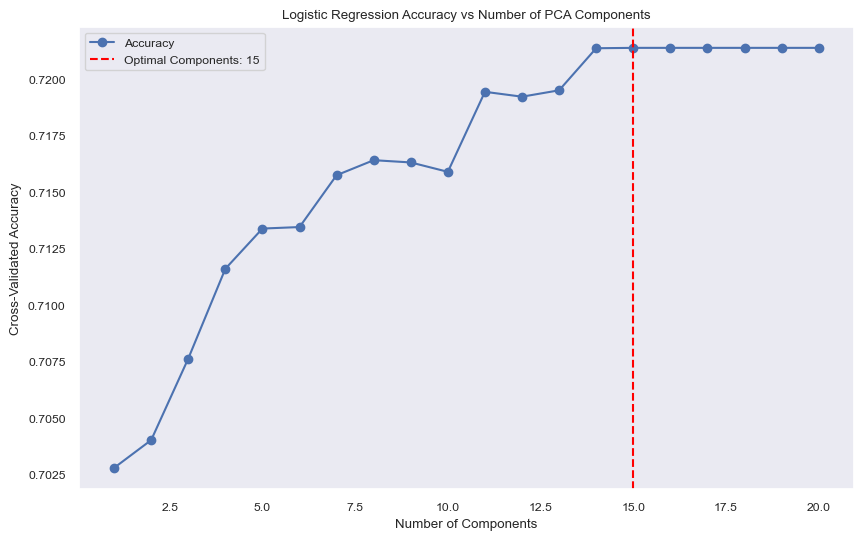

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

max_components = min(X.shape)
accuracies = []

# Iterate through each possible number of components
for n in range(1, max_components + 1):
    # PCA with n components
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    
    # fit logistic Regression and evaluate using cross-validation
    model = LogisticRegression(max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    accuracies.append(np.mean(scores))

# find the optimal number of components
optimal_components = np.argmax(accuracies) + 1
best_accuracy = accuracies[optimal_components - 1]

print(f"Optimal number of components: {optimal_components}")
print(f"Best accuracy: {best_accuracy:.4f}")

# accuracy vs number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), accuracies, marker='o', label='Accuracy')
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'Optimal Components: {optimal_components}')
plt.title('Logistic Regression Accuracy vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.show()


In [24]:
N_COMPONENTS = 15

In [25]:
pca = PCA(n_components=N_COMPONENTS)
principal_components = pca.fit_transform(X_train)

pca_df = pd.DataFrame(data=principal_components)

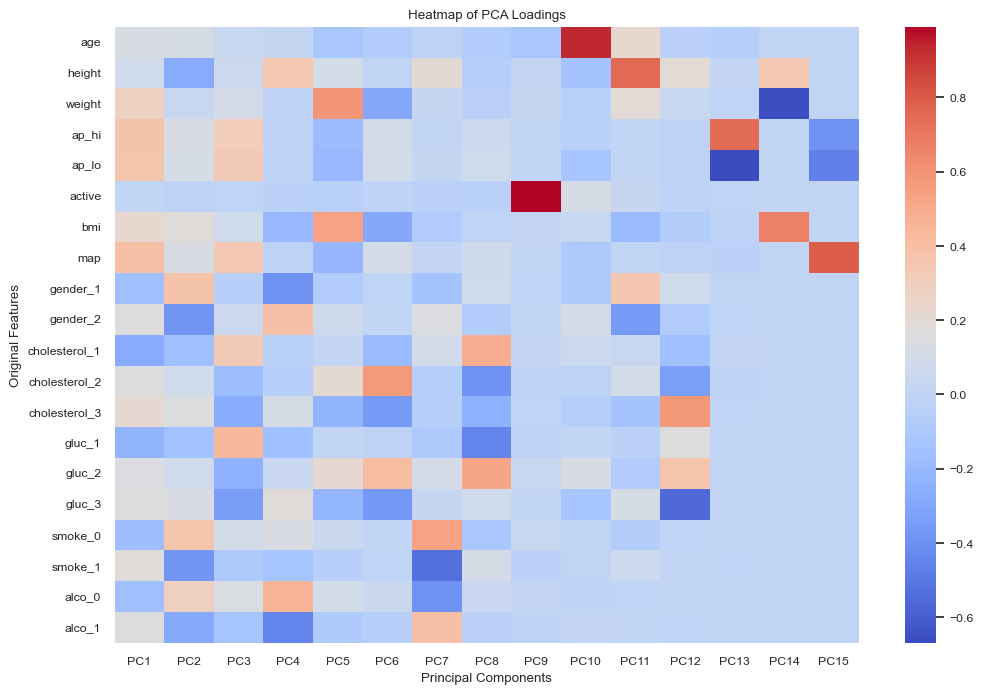

In [26]:
import seaborn as sns
import pandas as pd

# PCA components
components = pd.DataFrame(pca.components_, columns=X.columns,
                          index=[f'PC{i+1}' for i in range(N_COMPONENTS)])

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(components.T, cmap='coolwarm', annot=False)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()


In [27]:
pca = PCA(n_components=N_COMPONENTS)
principal_components_train = pca.fit_transform(X_train)

# transform the test data
principal_components_test = pca.transform(X_test)

# create DataFrames for the transformed data
X_train = pd.DataFrame(data=principal_components_train, columns=[f'PC{i+1}' for i in range(N_COMPONENTS)])
X_test = pd.DataFrame(data=principal_components_test, columns=[f'PC{i+1}' for i in range(N_COMPONENTS)])

pca_scaler = StandardScaler()
X_train = pca_scaler.fit_transform(X_train)
X_test = pca_scaler.transform(X_test)

# Predictive Modeling

## Logistic Regression

In [28]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7209244326211656

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      6147
           1       0.75      0.64      0.69      5882

    accuracy                           0.72     12029
   macro avg       0.73      0.72      0.72     12029
weighted avg       0.72      0.72      0.72     12029



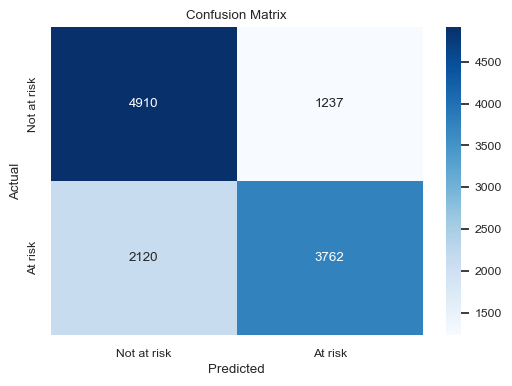

In [29]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not at risk', 'At risk'], yticklabels=['Not at risk', 'At risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Naive Approaches

In [31]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = {}
metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    accuracies[name] = accuracy
    metrics[name] = [precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)]

Training Logistic Regression...
Logistic Regression Accuracy: 0.7209244326211656
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      6147
           1       0.75      0.64      0.69      5882

    accuracy                           0.72     12029
   macro avg       0.73      0.72      0.72     12029
weighted avg       0.72      0.72      0.72     12029

Training Decision Tree...
Decision Tree Accuracy: 0.6205004572283648
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      6147
           1       0.61      0.61      0.61      5882

    accuracy                           0.62     12029
   macro avg       0.62      0.62      0.62     12029
weighted avg       0.62      0.62      0.62     12029

Training Random Forest...
Random Forest Accuracy: 0.6917449497048799
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      6147
           1      

/opt/anaconda3/envs/csc240/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.7158533543935489
              precision    recall  f1-score   support

           0       0.70      0.77      0.74      6147
           1       0.73      0.66      0.69      5882

    accuracy                           0.72     12029
   macro avg       0.72      0.71      0.71     12029
weighted avg       0.72      0.72      0.71     12029

Training Naive Bayes...
Naive Bayes Accuracy: 0.6610690830492976
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      6147
           1       0.69      0.57      0.62      5882

    accuracy                           0.66     12029
   macro avg       0.67      0.66      0.66     12029
weighted avg       0.66      0.66      0.66     12029



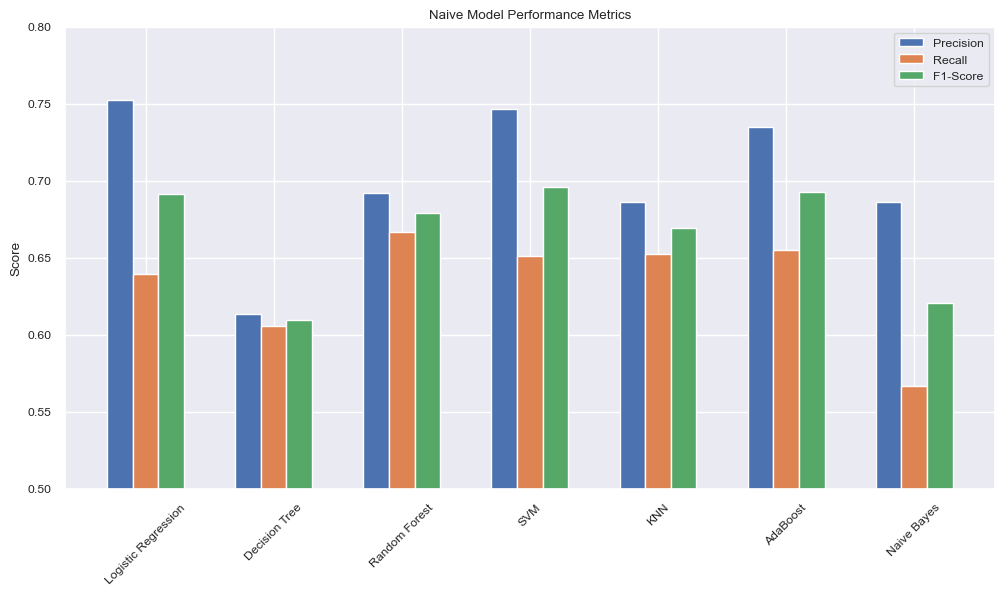

In [32]:
labels = list(metrics.keys())
precision = [metrics[model][0] for model in labels]
recall = [metrics[model][1] for model in labels]
f1_score = [metrics[model][2] for model in labels]

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.title('Naive Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(x, labels, rotation=45)
plt.ylim(0.5, 0.8)
plt.legend()
plt.show()


## Deep Learning

In [33]:
# train-validation-test (70-15-15) split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=N_COMPONENTS)
principal_components_train = pca.fit_transform(X_train)

# transform the test data
principal_components_val = pca.transform(X_val)
principal_components_test = pca.transform(X_test)

# create DataFrames for the transformed data
X_train = pd.DataFrame(data=principal_components_train, columns=[f'PC{i+1}' for i in range(N_COMPONENTS)])
X_val = pd.DataFrame(data=principal_components_val, columns=[f'PC{i+1}' for i in range(N_COMPONENTS)])
X_test = pd.DataFrame(data=principal_components_test, columns=[f'PC{i+1}' for i in range(N_COMPONENTS)])

pca_scaler = StandardScaler()
X_train = pca_scaler.fit_transform(X_train)
X_test = pca_scaler.transform(X_test)
X_val = pca_scaler.transform(X_val)

# create tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)


# Feed Forward Neural Network
class Network(nn.Module):
    def __init__(self, input_dim):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)

        self.fc4 = nn.Linear(32, 1)

        self._init_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.fc4(x)  # raw logits
        return x

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:      
                    nn.init.zeros_(layer.bias)


# initialize model
input_dim = X_train_tensor.shape[1]
model = Network(input_dim)

# calculate num_batches
batch_size = 32
epochs = 50
num_batches = math.ceil(len(X_train_tensor) / batch_size)

# loss function, optimizer, scheduler

class_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight]))

optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0005,
    steps_per_epoch=num_batches,
    epochs=epochs
)

# initialize lists to log losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_correct = 0
    train_total = 0

    for i in range(0, len(X_train_tensor), batch_size):
        # mini-batch
        X_batch = X_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        # forward
        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # training accuracy
        train_preds = (torch.sigmoid(logits) >= 0.5).float()
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_accuracy = train_correct / train_total
    train_losses.append(total_loss / num_batches)
    train_accuracies.append(train_accuracy)

    # validation step
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        val_logits = model(X_val_tensor)
        val_loss = criterion(val_logits, y_val_tensor).item()

        val_preds = (torch.sigmoid(val_logits) >= 0.5).float()
        val_correct = (val_preds == y_val_tensor).sum().item()
        val_total = y_val_tensor.size(0)

    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # progress update
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {total_loss / num_batches:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

# save the model
torch.save(model.state_dict(), 'feed_forward_network.pth')

# test evaluation
model.eval()
with torch.no_grad():
    y_test_logits = model(X_test_tensor)
    y_test_pred_classes = (torch.sigmoid(y_test_logits) >= 0.5).float()
    test_correct = (y_test_pred_classes == y_test_tensor).sum().item()
    test_total = y_test_tensor.size(0)
    test_accuracy = test_correct / test_total
    accuracies['FFNN'] = test_accuracy

print(f"Final Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50, Train Loss: 0.7547, Train Acc: 0.5480, Val Loss: 0.6607, Val Acc: 0.6424
Epoch 10/50, Train Loss: 0.5848, Train Acc: 0.7147, Val Loss: 0.5726, Val Acc: 0.7229
Epoch 20/50, Train Loss: 0.5736, Train Acc: 0.7233, Val Loss: 0.5677, Val Acc: 0.7235
Epoch 30/50, Train Loss: 0.5705, Train Acc: 0.7243, Val Loss: 0.5672, Val Acc: 0.7239
Epoch 40/50, Train Loss: 0.5689, Train Acc: 0.7265, Val Loss: 0.5668, Val Acc: 0.7233
Epoch 50/50, Train Loss: 0.5691, Train Acc: 0.7254, Val Loss: 0.5665, Val Acc: 0.7240
Final Test Accuracy: 0.7280


In [34]:
# Code for architecture

# from torchviz import make_dot
# import torch

# dummy_input = torch.randn(1, input_dim)
# output = model(dummy_input)

# graph = make_dot(output, params=dict(model.named_parameters()))
# graph.render("ffnn_architecture", format="png", cleanup=True)


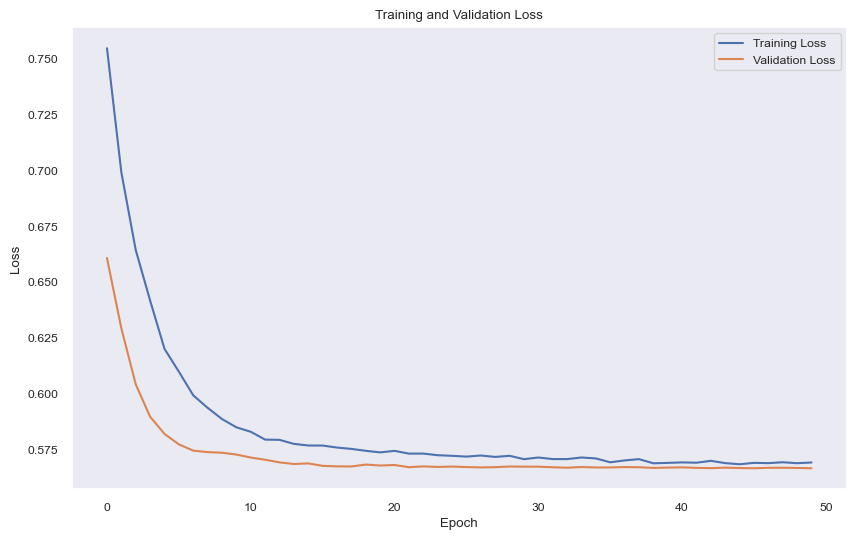

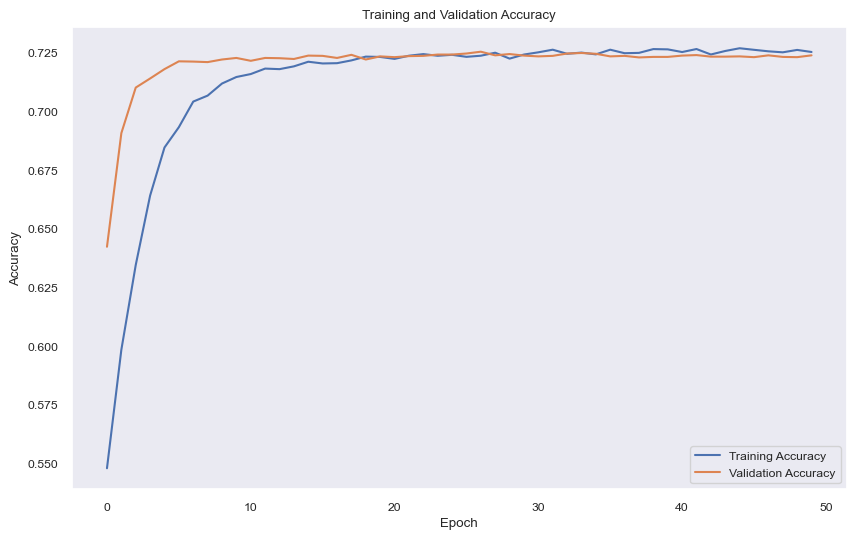

In [35]:
import matplotlib.pyplot as plt

# training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Boosting Methods

In [36]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Grid Search
#### XGBoost

In [37]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# initialize model
xgb_model = XGBClassifier(objective='binary:logistic', seed=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsam

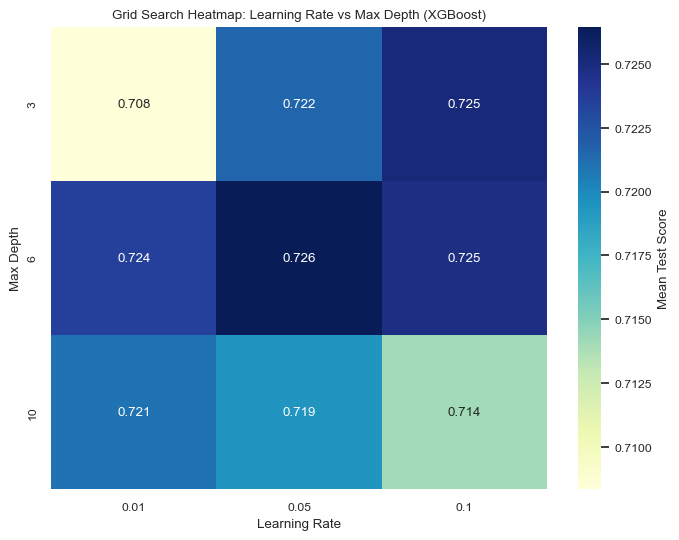

In [38]:
results = pd.DataFrame(grid_search.cv_results_)

heatmap_data = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_learning_rate'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Heatmap: Learning Rate vs Max Depth (XGBoost)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()


#### LightGBM

In [39]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],       
    'n_estimators': [200],
    'max_depth': [3, 5, 10], 
    'num_leaves': [15, 31],
    'min_data_in_leaf': [20, 50],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.8] 
}

# initialize model
lgbm = LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1
)

grid_search.fit(X_train, y_train)

# best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# best parameters on test data
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 13686, number of negative: 14380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to 

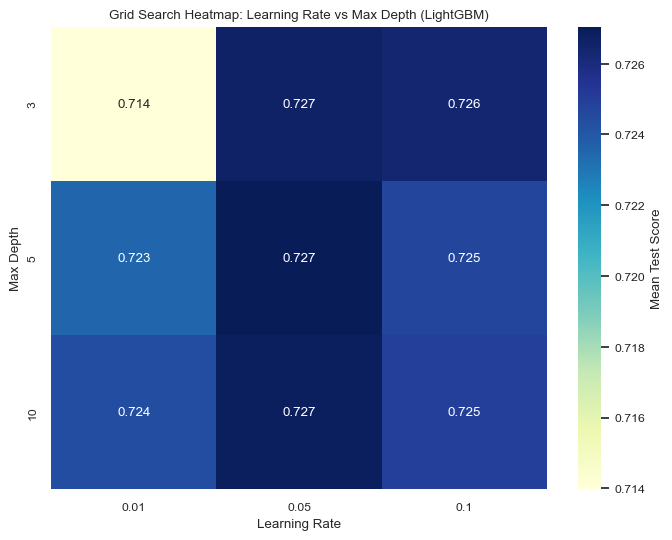

In [40]:
results = pd.DataFrame(grid_search.cv_results_)

# Learning rate vs Max Depth
heatmap_data = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_learning_rate'
)

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Heatmap: Learning Rate vs Max Depth (LightGBM)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()


##### Results obtained from Grid Search

In [41]:
model = XGBClassifier(objective='binary:logistic',colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=400, seed=42)

model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.68187
[1]	validation_0-logloss:0.67154
[2]	validation_0-logloss:0.66237
[3]	validation_0-logloss:0.65406
[4]	validation_0-logloss:0.64627
[5]	validation_0-logloss:0.63929
[6]	validation_0-logloss:0.63358
[7]	validation_0-logloss:0.62784
[8]	validation_0-logloss:0.62303
[9]	validation_0-logloss:0.61793
[10]	validation_0-logloss:0.61307
[11]	validation_0-logloss:0.60873
[12]	validation_0-logloss:0.60473
[13]	validation_0-logloss:0.60114
[14]	validation_0-logloss:0.59785
[15]	validation_0-logloss:0.59461
[16]	validation_0-logloss:0.59165
[17]	validation_0-logloss:0.58891
[18]	validation_0-logloss:0.58639
[19]	validation_0-logloss:0.58397
[20]	validation_0-logloss:0.58214
[21]	validation_0-logloss:0.58004
[22]	validation_0-logloss:0.57841
[23]	validation_0-logloss:0.57690
[24]	validation_0-logloss:0.57525
[25]	validation_0-logloss:0.57384
[26]	validation_0-logloss:0.57269
[27]	validation_0-logloss:0.57155
[28]	validation_0-logloss:0.57036
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
predictions=model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Boosting'] = accuracy
print('Accuracy Score: ', accuracy_score(y_test, predictions))

Accuracy Score:  0.725227222345378


In [43]:
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('xgb', XGBClassifier(objective='binary:logistic',colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=400, seed=42)),
    ('lgbm', LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, max_depth=5, min_data_in_leaf=50, n_estimators=200, num_leaves=31, seed=42))
]

In [44]:
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()  
)

In [45]:
stack_model.fit(X_train, y_train)
accuracy = stack_model.score(X_test, y_test)
accuracies['Ensemble Learning'] = accuracy

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 20530, number of negative: 21569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightG

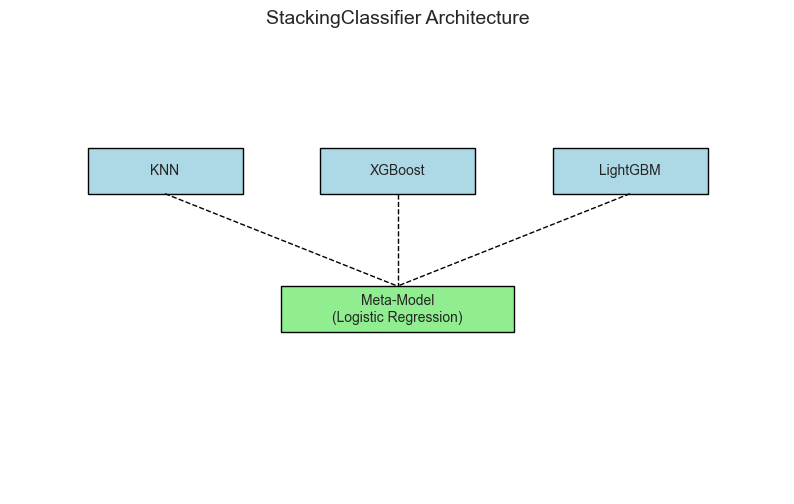

In [46]:

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# base models
base_models = ['KNN', 'XGBoost', 'LightGBM']
base_coords = [(0.2, 0.7), (0.5, 0.7), (0.8, 0.7)]

# meta-model
meta_coords = (0.5, 0.4)

# draw base
for i, model in enumerate(base_models):
    x, y = base_coords[i]
    rect = Rectangle((x - 0.1, y - 0.05), 0.2, 0.1, edgecolor='black', facecolor='lightblue')
    ax.add_patch(rect)
    ax.text(x, y, model, ha='center', va='center', fontsize=10)

# draw meta
meta_rect = Rectangle((meta_coords[0] - 0.15, meta_coords[1] - 0.05), 0.3, 0.1, edgecolor='black', facecolor='lightgreen')
ax.add_patch(meta_rect)
ax.text(meta_coords[0], meta_coords[1], 'Meta-Model\n(Logistic Regression)', ha='center', va='center', fontsize=10)

# draw arrows
for x, y in base_coords:
    arrow = Line2D([x, meta_coords[0]], [y - 0.05, meta_coords[1] + 0.05], color='black', linewidth=1, linestyle='--')
    ax.add_line(arrow)

plt.title('StackingClassifier Architecture', fontsize=14)
plt.show()

In [47]:
print(f"Ensemble Learning Accuracy: {accuracy * 100:.2f}%")

Ensemble Learning Accuracy: 72.80%


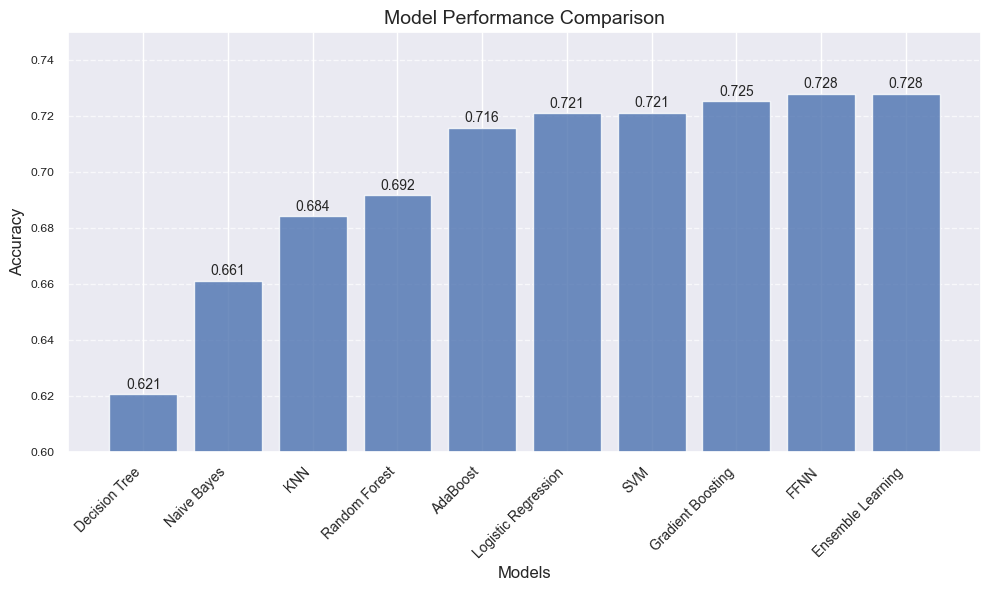

In [48]:
accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1]))
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), alpha=0.8)
plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylim(0.6, 0.75)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# annotate scores on bars
for i, (model, score) in enumerate(accuracies.items()):
    plt.text(i, score + 0.002, f"{score:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()